In [1]:
%matplotlib inline
%pdb on

from pprint import pprint
import itertools
import numpy

from metrics import wer, cew, ssr, average, hreff
import montecarlo
import market
import dms
import withdrawal
import mortality
from portfolio import Portfolio
import harvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

Automatic pdb calling has been turned ON


In [2]:
survival_function = mortality.make_mortality(mortality.ANNUITY_2000)

In [3]:
HREFF_FLOOR = 3

In [4]:
def run_one_new(dataset, strategy, hreff_floor=HREFF_FLOOR, debug_cashflows=False):
    p = Portfolio(600000, 400000)
    h = strategy(p).harvest()
    h.send(None)
    #w = withdrawal.VPW(p, h, years_left=35).withdrawals()
    w = withdrawal.ConstantDollar(p, h).withdrawals()
    
    def add_debug_log(annual):
        if debug_cashflows:
            debug.append({
                'Returns' : annual.returns,
                'Withdraw' : annual.withdraw_n,
                'Portfolio' : annual.portfolio_n,
                'Withdraw Orig' : annual.withdraw_pct_orig,
            })

    cashflows = []
    returns = []
    debug = []

    # Initial withdrawal at start of retirement
    annual = w.send(None)
    add_debug_log(annual)
    
    cashflows.append(annual.withdraw_pct_orig)
    
    for i in dataset:
        annual = w.send(i)
        add_debug_log(annual)

        returns.append(annual.returns)
        cashflows.append(annual.withdraw_pct_orig)

    if debug_cashflows:
        pandas.DataFrame(data=debug).to_csv('WERCOMP-cashflows.csv')

    w = wer(cashflows, returns)
    h = hreff(cashflows, returns, floor=D(hreff_floor)/100)
    return (w, h, returns)

In [5]:
def run_bootstrap(strategies, runs=1000, dataset=montecarlo.historical[60]):
    wer_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    hreff_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    returns_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[i for i in range(60)])

    for i in range(runs):
        # First generate a lifespan, so we know how many years of returns we need to generate
        lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_function)

        returns = (dataset.random_year() for y in range(lifespan))
        pairs = zip(strategies, itertools.tee(returns, len(strategies)))
      
        for (s, r) in pairs:
            (wer, hreff, returns) = run_one_new(r, s)
            wer_df.loc[i][s.__name__] = wer
            hreff_df.loc[i][s.__name__] = hreff
            
            returns_df.loc[i] = returns + [None for _ in range(60-lifespan)]
            
    return (wer_df, hreff_df, returns_df)

In [6]:
def run_sequential(strategies, dataset):
    runs = len(dataset)
    wer_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    hreff_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    returns_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[i for i in range(60)])

    lifespan = 30

    for i in range(runs - lifespan):
        returns = itertools.islice(dataset.iter_from(dataset.start_year + i), lifespan)
        
        pairs = zip(strategies, itertools.tee(returns, len(strategies)))
      
        for (s, r) in pairs:
            (wer, hreff, returns) = run_one_new(r, s)
            wer_df.loc[i][s.__name__] = wer
            hreff_df.loc[i][s.__name__] = hreff
            
            returns_df.loc[i] = returns + [None for _ in range(60-lifespan)]
            
    return (wer_df, hreff_df, returns_df)

In [7]:
strategies = [
    harvesting.N_60_RebalanceHarvesting,
    harvesting.N_100_RebalanceHarvesting,
    harvesting.PrimeHarvesting,
    harvesting.AltPrimeHarvesting,
    harvesting.BondsFirst,
    harvesting.OmegaNot,
    harvesting.Weiss,
    harvesting.AgeBased_100,
    harvesting.AgeBased_110,
    harvesting.AgeBased_120,
    harvesting.Glidepath,
    harvesting.InverseGlidepath,
    harvesting.ActuarialHarvesting,
]

In [8]:
def make_report(df):
    d = [(col, series.mean()) for (col, series) in df.iteritems()]
    new_df = pandas.Series(dict(d))
    new_df.sort_values(inplace=True)
    return new_df

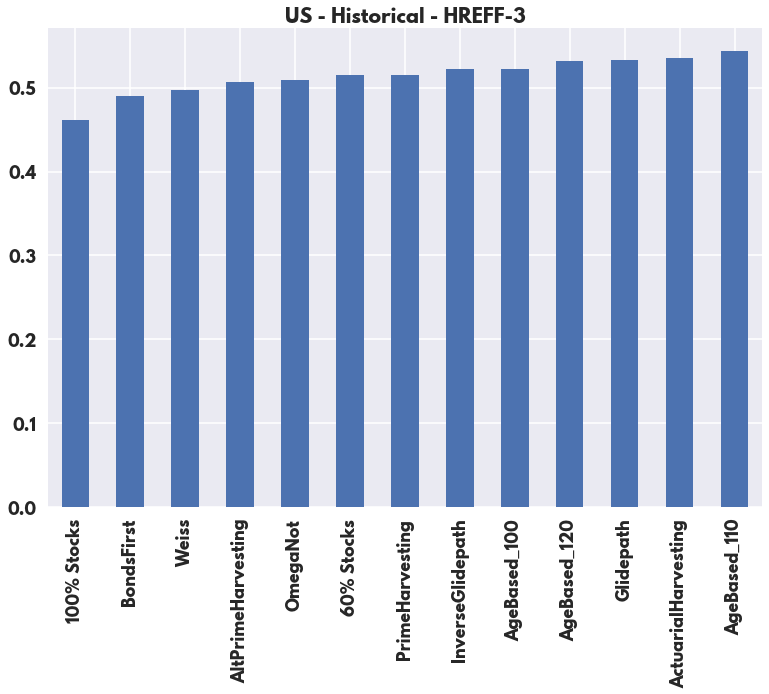

In [9]:
wer_df, hreff_df, returns_df = run_sequential(strategies, market.Returns_US_1871())
#make_report(wer_df).plot(kind='bar', title='US - Historical - WER')
make_report(hreff_df).plot(kind='bar', title='US - Historical - HREFF-%d' % HREFF_FLOOR)

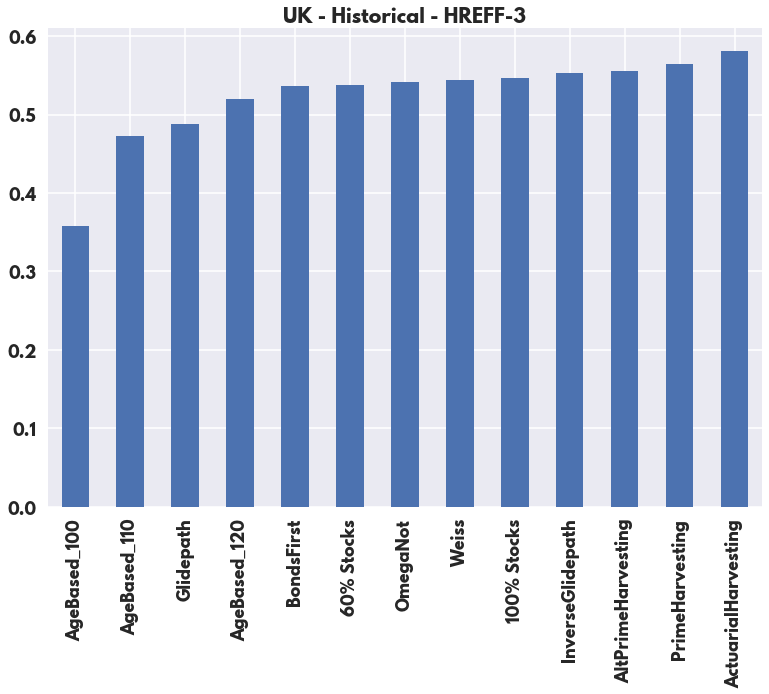

In [10]:
wer_df, hreff_df, returns_df = run_sequential(strategies, market.UK1900())
#make_report(wer_df).plot(kind='bar', title='UK - Historical - WER')
make_report(hreff_df).plot(kind='bar', title='UK - Historical - HREFF-%d' % HREFF_FLOOR)

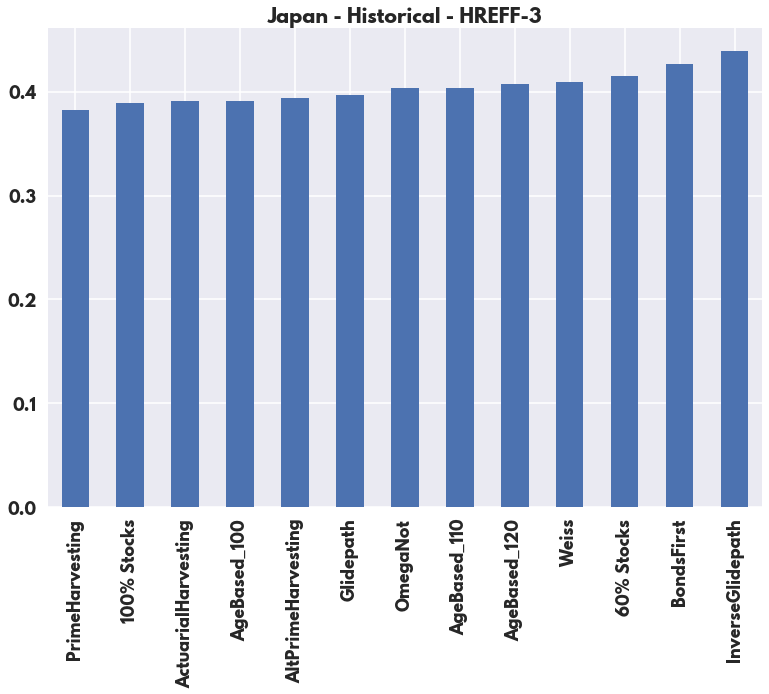

In [11]:
wer_df, hreff_df, returns_df = run_sequential(strategies, market.Japan_1957())
#make_report(wer_df).plot(kind='bar', title='Japan - Historical - WER')
make_report(hreff_df).plot(kind='bar', title='Japan - Historical - HREFF-%d' % HREFF_FLOOR)

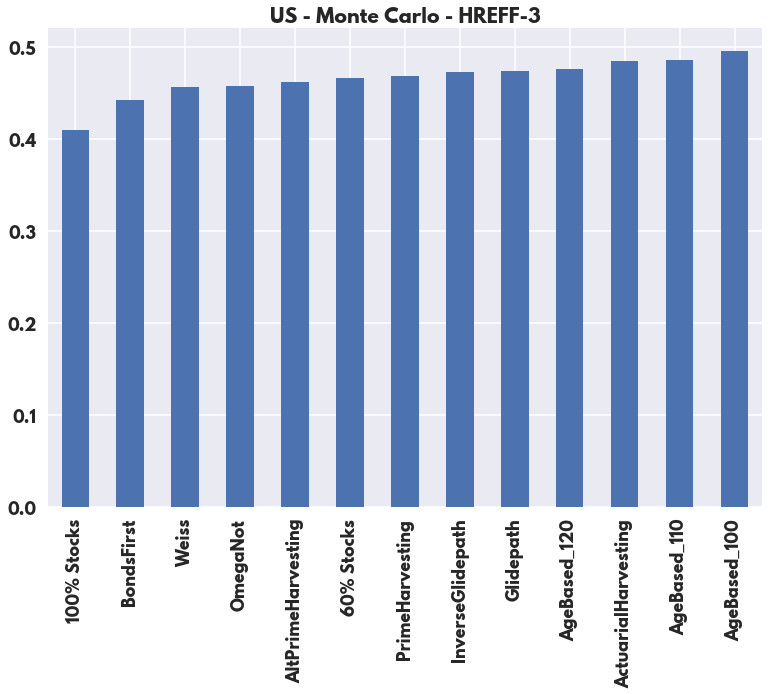

In [12]:
wer_df, hreff_df, returns_df = run_bootstrap(strategies, runs=1000, dataset=market.Returns_US_1871())
#make_report(wer_df).plot(kind='bar', title='US - Monte Carlo - WER')
make_report(hreff_df).plot(kind='bar', title='US - Monte Carlo - HREFF-%d' % HREFF_FLOOR)

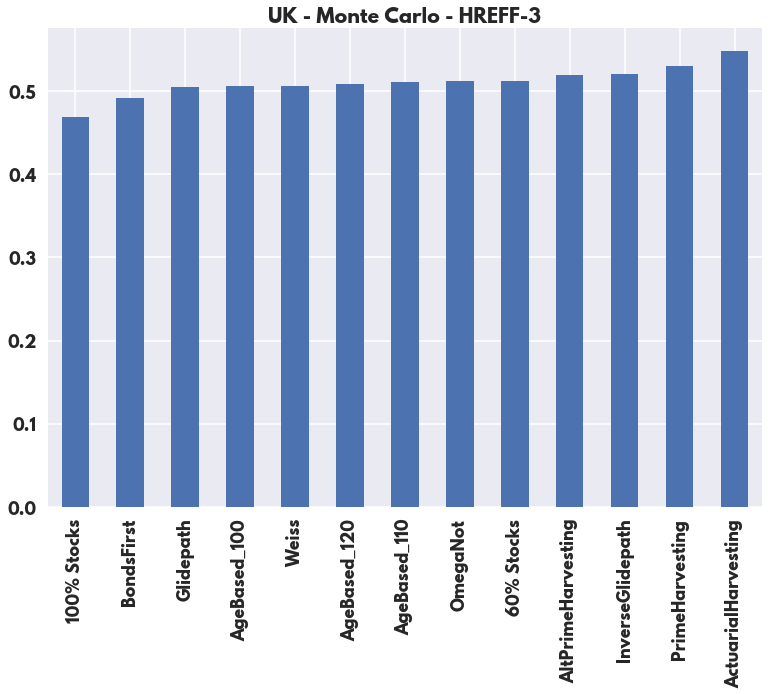

In [13]:
wer_df, hreff_df, returns_df = run_bootstrap(strategies, runs=1000, dataset=market.UK1900())
#make_report(wer_df).plot(kind='bar', title='UK - Monte Carlo - WER')
make_report(hreff_df).plot(kind='bar', title='UK - Monte Carlo - HREFF-%d' % HREFF_FLOOR)

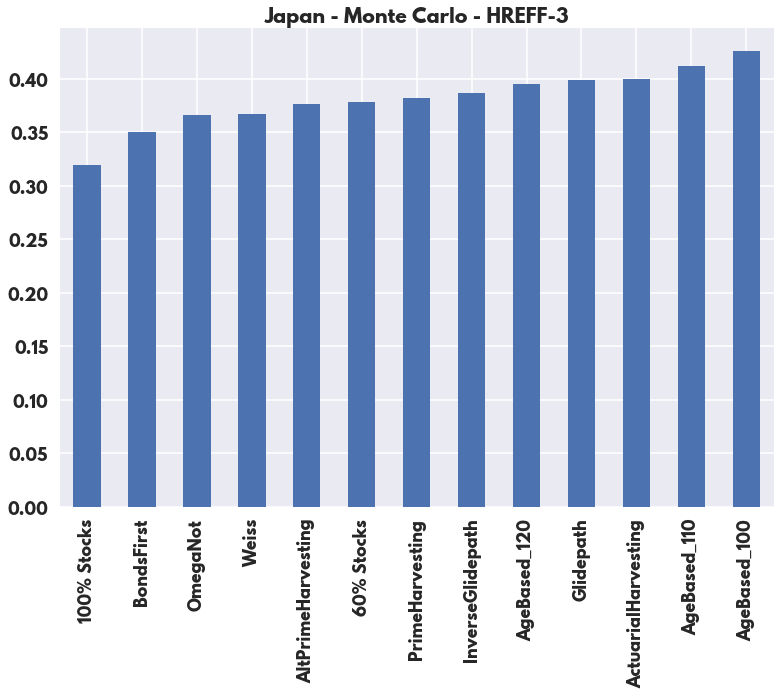

In [14]:
wer_df, hreff_df, returns_df = run_bootstrap(strategies, runs=1000, dataset=market.Japan_1957())
#make_report(wer_df).plot(kind='bar', title='Japan - Monte Carlo - WER')
make_report(hreff_df).plot(kind='bar', title='Japan - Monte Carlo - HREFF-%d' % HREFF_FLOOR)